In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Zendesk Global queue analysis

## Terms used

* **SLA**: Stands for Service Level Agreement. 
* **SLO**: Stands for Service Level Objective.
* **SLA policy**: A Zendesk configuration term. A policy applied to a ticket which results in an _SLA event_ being created, with rules around when the SLA event clock counts down and when it is paused.
* **SLA event**: A Zendesk configuration term. Refers to a specific instance of an SLA policy.

### SLAs vs SLOs

In GitLab Support, "SLA" is used to refer to service standards which we are contractually obliged to provide. In practice, this means responding to a customer's first message in a ticket under a certain length of time, also known as first response time (FRT).

"SLO" is used to refer to service standards which GitLab Support aims to provide, but is not contractually obliged to do so. In practice, these are response times to subsequent customer messages after the first, also known as next response time (NRT).

In this analysis, "SLA" will be used to refer to Zendesk SLA events, and covers both SLAs and SLOs terms as used by GitLab Support. The difference is not material as this analysis is primarily concerned with:

1. work coming into the queues
1. work done over time
1. work completed and pushed out of the queues

### Unit of work

For work in Zendesk, the smallest **unit of work** is:

* A customer sends Support a message, creating an SLA event
* A support engineer replies to the customer's message, completing the SLA event

Further to this, the following definitions are used:

* **Arrival rate**: The number of incoming customer messages creating an SLA event over a fixed period of time. The unit of measurement as used in this analysis is `messages per hour`.
* **Service rate**: The length of time taken for a support engineer to work out a respond to a customer message. The unit of measurement as used in this analysis is `messages per hour`.

Unless otherwise qualified, all further mentions of _arrival rate_ and _service rate_ will be taken to be the **average** over a specified period in time.

## Division of the global day

Before deriving arrival rates and service rates, we need to define the time periods used for calculating these metrics. The [Support Hours defined by Preferred Region for Support](https://about.gitlab.com/support/#effect-on-support-hours-if-a-preferred-region-for-support-is-chosen) is a good starting point:

| Region | Anchor TZ | Local start | Local end | UTC start | UTC end | Length of day |
|--------|-----------|-------------|-----------|-----------|---------|---------------|
| AMER   | PT        | 05:00       | 17:00     | 13:00     | 01:00   | 12 hours      |
| APAC   | AEST      | 09:00       | 22:00     | 22:00     | 11:00   | 13 hours      |
| EMEA   | CET       | 08:00       | 18:00     | 07:00     | 17:00   | 10 hours      |

Note: AMER and EMEA experience clock shifts due to daylight savings time (DST) at various times of the year. The times used here do not take into account DST.

These time periods overlap, both in terms of SLA active clock times, and in terms of support engineers' availability. To properly capture these overlaps and take them into consideration in planning and developing actionables, the following time segments are used in this analysis.

| Region      | Anchor TZ | Local start | Local end | UTC start | UTC end | Length of day | Notes                          |
|-------------|-----------|-------------|-----------|-----------|---------|---------------|--------------------------------|
| AMER-Early  | PT        | 05:00       | 09:00     | 13:00     | 17:00   | 4 hours       | Overlap with EMEA-Late         |
| AMER-Middle | PT        | 09:00       | 13:00     | 17:00     | 21:00   | 4 hours       | Minimal overlap with EMEA-Late |
| AMER-Late   | PT        | 13:00       | 17:00     | 21:00     | 01:00   | 4 hours       | Overlap with APAC-Early        |
| APAC-Early  | AEST      | 09:00       | 13:00     | 22:00     | 02:00   | 4 hours       | Overlap with AMER-Late         |
| APAC-Middle | AEST      | 13:00       | 18:00     | 02:00     | 07:00   | 5 hours       | No overlap                     |
| APAC-Late   | AEST      | 18:00       | 22:00     | 07:00     | 11:00   | 4 hours       | Overlap with EMEA-Early        |
| EMEA-Early  | CET       | 08:00       | 12:00     | 07:00     | 11:00   | 4 hours       | Overlap with APAC-Late         |
| EMEA-Late   | CET       | 12:00       | 18:00     | 11:00     | 17:00   | 6 hours       | Overlap with AMER-Early        |

These time segments were intentionally named 'Early', 'Middle' and 'Late' to avoid name collision and misassociation with geographic designators, such as 'East', 'Central' and 'West'.


## Arrival rate



### Source data

The source data for arrival rates are derived from [this Zendesk Explore query](https://gitlab.zendesk.com/explore#/pivot-table/connection/8687841/query/57047572). It designed to count the number of customer updates which trigger an SLA for each hour and each day of each month. 

Metrics:

1. D_COUNT(Updates)

Columns:

1. Update - Hour

Rows:

1. Ticket form (includes only `L&R`, `SaaS`, `SaaS Account`, `Self-Managed`)
1. Update - Year
1. Update - Month
1. Update - Day of Month
1. Update - Day of week

Filters:

1. Updater role (includes only `End-user`)
1. Changes - Previous value (includes only `NULL`, `closed`, `new`, `pending`, `solved`)
1. Comment type (includes only `Public`)
1. Update ticket status (includes only `new`, `open`)

Note: 

* Dates are filtered under "Advanced" to "From of beginning of `2020-01-01`" to "To the end of `1 month in the past`".
* **IMPORTANT** Your Zendesk profile timezone must be set to UTC.


### Importing, cleaning & filtering

In [2]:
arrivals_data = pd.read_csv('../_inputs/arrival_data_-_up_to_2021-02-28.csv')
arrivals_data['Updates'].fillna(value=0, inplace=True)

First, we remove weekends from the data set so averages are not adversely affected by the low number of arrivals during these times.

In [3]:
# Filter out weekends
weekday_mask = (arrivals_data['Update - Weekday'] != 'Saturday') & (arrivals_data['Update - Weekday'] != 'Sunday')
weekday_arrivals_data = arrivals_data[weekday_mask]

all_update_counts = arrivals_data['Updates'].sum()
weekday_update_counts = weekday_arrivals_data['Updates'].sum()
print('Number of updates before filtering weekends: ' + str(arrivals_data['Updates'].sum()))
print('Number of updates after filtering weekends: ' + str(weekday_arrivals_data['Updates'].sum()))
print('Difference: ' + str(all_update_counts - weekday_update_counts) + ' (' + str(round((1 - weekday_update_counts / all_update_counts) * 100, 2)) + '%)')

Number of updates before filtering weekends: 110991.0
Number of updates after filtering weekends: 105729.0
Difference: 5262.0 (4.74%)


In [4]:
%%capture
# Create masks for regions
hours = arrivals_data['Update - Hour']

amer_mask = (hours >= 13) | (hours < 1)
amer_e_mask = (hours >= 13) & (hours < 17)
amer_m_mask = (hours >= 17) & (hours < 21)
amer_l_mask = (hours >= 21) | (hours < 1)

apac_mask = (hours >= 22) | (hours < 11)
apac_e_mask = (hours >= 22) | (hours < 2)
apac_m_mask = (hours >= 2) & (hours < 7)
apac_l_mask = (hours >= 7) & (hours < 11)

emea_mask = (hours >= 7 ) & (hours < 17)
emea_e_mask = (hours >= 7) & (hours < 12)
emea_l_mask = (hours >= 12) & (hours < 17)

# Create regional datasets
amer_arrivals_data = weekday_arrivals_data[amer_mask]
amer_e_arrivals_data = weekday_arrivals_data[amer_e_mask]
amer_m_arrivals_data = weekday_arrivals_data[amer_m_mask]
amer_l_arrivals_data = weekday_arrivals_data[amer_l_mask]

apac_arrivals_data = weekday_arrivals_data[apac_mask]
apac_e_arrivals_data = weekday_arrivals_data[apac_e_mask]
apac_m_arrivals_data = weekday_arrivals_data[apac_m_mask]
apac_l_arrivals_data = weekday_arrivals_data[apac_l_mask]

emea_arrivals_data = weekday_arrivals_data[emea_mask]
emea_e_arrivals_data = weekday_arrivals_data[emea_e_mask]
emea_l_arrivals_data = weekday_arrivals_data[emea_l_mask]

regional_arrivals_data = {
    'AMER-All': amer_arrivals_data,
    'AMER-Early': amer_e_arrivals_data,
    'AMER-Middle': amer_m_arrivals_data,
    'AMER-Late': amer_l_arrivals_data,
    'APAC-All': apac_arrivals_data,
    'APAC-Early': apac_e_arrivals_data,
    'APAC-Middle': apac_m_arrivals_data,
    'APAC-Late': apac_l_arrivals_data,
    'EMEA-All': emea_arrivals_data,
    'EMEA-Early': emea_e_arrivals_data,
    'EMEA-Late': emea_l_arrivals_data,
}

### Transforming

In [5]:
years = arrivals_data['Update - Year'].unique()
months = arrivals_data['Update - Month'].unique()
forms = arrivals_data['Ticket form'].unique()

arrival_rates_cols = ['Region', 'Form', 'Month', 'Arrival Rate']
arrival_rates_data = []

for region_name, data in regional_arrivals_data.items():
    for year in years:
        year_data = data[data['Update - Year'] == year]

        for month in months:
            month_data = year_data[year_data['Update - Month'] == month]

            for form in forms:
                form_data = month_data[month_data['Ticket form'] == form]
                
                updates_avg = form_data['Updates'].mean()
                if np.isnan(updates_avg): continue

                row_data = [
                    region_name, 
                    form,
                    pd.to_datetime(str(year) + month, format='%Y%B'),
                    form_data['Updates'].mean()
                ]                

                arrival_rates_data.append(row_data)

            row_data = [
                region_name,
                'All',
                pd.to_datetime(str(year) + month, format='%Y%B'),
                month_data['Updates'].mean()
            ]

            arrival_rates_data.append(row_data)

arrival_rates_df = pd.DataFrame(arrival_rates_data, columns=arrival_rates_cols)


### Analysis

In [6]:
fig, ax = plt.subplots(5, 3, sharey=True, figsize=[16, 25])
fig.suptitle('Arrival rate for all queues')
fig.tight_layout()

for i, form in enumerate(['All', 'Self-Managed', 'L&R', 'SaaS', 'SaaS Account']):
    for region in ['AMER-All', 'AMER-Early', 'AMER-Middle', 'AMER-Late']:
        mask = (arrival_rates_df['Region'] == region) & (arrival_rates_df['Form'] == form)
        data = arrival_rates_df[mask]
        ax[i, 0].plot(data['Month'], data['Arrival Rate'], label=region)
    ax[i, 0].set_title(form)
    ax[i, 0].legend()

    for region in ['APAC-All', 'APAC-Early', 'APAC-Middle', 'APAC-Late']:
        mask = (arrival_rates_df['Region'] == region) & (arrival_rates_df['Form'] == form)
        data = arrival_rates_df[mask]
        ax[i, 1].plot(data['Month'], data['Arrival Rate'], label=region)
    ax[i, 1].legend()

    for region in ['EMEA-All', 'EMEA-Early', 'EMEA-Late']:
        mask = (arrival_rates_df['Region'] == region) & (arrival_rates_df['Form'] == form)
        data = arrival_rates_df[mask]
        ax[i, 2].plot(data['Month'], data['Arrival Rate'], label=region)
    ax[i, 2].legend()

plt.show()

#### AMER

The three different AMER time segments each have their own distinct band of arrival rates. Of note is that the total average of AMER hides that AMER-Early has an outsized arrival rate.

#### APAC

APAC-Late has an outsized arrival rate compared to the other time segments, most likely due to significant overlap with the EMEA-Early time segment.

#### EMEA

EMEA-Early and EMEA-Late each have their own distinct band of arrival rates. EMEA-Late's elevated arrival rates are most likely driven by overlap with the AMER-Early time segment.

#### Further analysis

It might be instructive to determine arrival rates by customer geo.


### High overlap in sub-region with handovers

These graphs demonstrate the high correlation of sub-region with handovers. This tends to validate the choice of sub-region segmentation chosen for the purposes of this analysis.

In [7]:

fig, ax = plt.subplots(1, 3, sharey=True, figsize=[16, 5])
fig.suptitle('Arrival rate for all queues in handover sub-regions')
fig.tight_layout()

for region in ['AMER-Early', 'APAC-Late']:
    mask = (arrival_rates_df['Region'] == region) & (arrival_rates_df['Form'] == 'All')
    data = arrival_rates_df[mask]
    ax[0].plot(data['Month'], data['Arrival Rate'], label=region)
ax[0].set_title('AMER <> APAC handover')
ax[0].legend()

for region in ['APAC-Late', 'EMEA-Early']:
    mask = (arrival_rates_df['Region'] == region) & (arrival_rates_df['Form'] == 'All')
    data = arrival_rates_df[mask]
    ax[1].plot(data['Month'], data['Arrival Rate'], label=region)
ax[1].set_title('APAC <> EMEA handover')
ax[1].legend()

for region in ['EMEA-Late', 'AMER-Early']:
    mask = (arrival_rates_df['Region'] == region) & (arrival_rates_df['Form'] == 'All')
    data = arrival_rates_df[mask]
    ax[2].plot(data['Month'], data['Arrival Rate'], label=region)
ax[2].set_title('EMEA <> AMER handover')
ax[2].legend()

plt.show()

## Service rates

The service rates of support engineers working each type of queue can be approximated by taking the time between each response that completes an SLA event.

### Source data

The source data for arrival rates are derived from these Zendesk Explore queries:

* [L&R](https://gitlab.zendesk.com/explore#/pivot-table/connection/8687841/query/58143932)
* [SaaS](https://gitlab.zendesk.com/explore#/pivot-table/connection/8687841/query/58143382)
* [SaaS Account](https://gitlab.zendesk.com/explore#/pivot-table/connection/8687841/query/58143412)
* [Self-Managed](https://gitlab.zendesk.com/explore#/pivot-table/connection/8687841/query/57679032)

These queries get a list of all updates which resulted in a support engineer completing an SLA event.

Metrics:

1. D_COUNT(Updates)

Rows:

1. Updater ID
1. Ticket form (includes `L&R`, `SaaS`, `SaaS Account`, `Self-Managed` depending on query)
1. Update - Timestamp

Filters:

1. Updater role (includes `Admin`, `Agent`)
1. Comment type (includes only `Public`)
1. Changes - Previous value (includes only `new`, `open`, `hold`)
1. Update ticket status (includes only `closed`, `deleted`, `pending`, `solved`)

Note: 

* Dates are filtered under "Advanced" to "From of beginning of `2020-01-01`" to "To the end of `1 month in the past`".
* **IMPORTANT** Your Zendesk profile timezone must be set to UTC.


### Importing, cleaning and filtering

In [8]:
service_data_files = {
    'L&R': '../_inputs/service_data_lr_-_up_to_2021-02-28.csv',
    'SaaS': '../_inputs/service_data_saas_-_up_to_2021-02-28.csv',
    'SaaS Account': '../_inputs/service_data_saas_account_-_up_to_2021-02-28.csv',
    'Self-Managed': '../_inputs/service_data_sm_-_up_to_2021-02-28.csv'
}

service_data = []
for form, filename in service_data_files.items():
    form_data = pd.read_csv(filename)
    
    form_data['Update - Timestamp'] = pd.to_datetime(form_data['Update - Timestamp'])
    form_data.sort_values(['Updater ID', 'Update - Timestamp'], inplace=True)

    # Calculate time between agent responses
    prev_row = pd.Series([], dtype=object)
    for i, row in form_data.iterrows():
        # Skip row if first row or Updater ID changes
        if not (prev_row.empty or (row['Updater ID'] != prev_row['Updater ID'])):
            service_time = row['Update - Timestamp'] - prev_row['Update - Timestamp']
            form_data.at[i, 'Service Time (mins)'] = round(service_time.total_seconds() / 60)
            form_data.at[i, 'Service Time (hrs)'] = service_time.total_seconds() / 60 / 60

        prev_row = row

    service_data.append(form_data)

service_data = pd.concat(service_data, ignore_index=True)

# Get rid of null data
service_data = service_data[service_data['Service Time (mins)'].notna()]

# Get rid of service times longer than 8 hours
# Note: 8 hours was chosen as anything longer would go beyond a typical work day
max_mask = service_data['Service Time (mins)'] <= 8 * 60
service_data = service_data[max_mask]

### Transforming

In [9]:
service_rates = service_data.groupby([
    pd.Grouper(key='Ticket form'),
    pd.Grouper(key='Update - Timestamp', freq='M')
]).mean().reset_index()

service_rates['Service Rate'] = 1 / service_rates['Service Time (hrs)']

### Analysis

In [10]:
sns.lineplot(x='Update - Timestamp', y='Service Time (mins)', data=service_rates, hue='Ticket form')
plt.show()

## Putting it together

In [11]:
total_availability = pd.read_csv('../_inputs/team_total_availability.csv')

total_availability = pd.melt(total_availability, id_vars=['Focus', 'Month'])
total_availability['variable'] = total_availability['variable'].apply(lambda row: int(row[5:]))

def focus_lr(value):
    mask = (service_rates['Ticket form'] == 'L&R') & (service_rates['Update - Timestamp'] == row['Month'])
    return service_rates[mask]['Service Rate'] * value

def focus_saas(value):
    mask = (service_rates['Ticket form'] == 'SaaS') & (service_rates['Update - Timestamp'] == row['Month'])
    return service_rates[mask]['Service Rate'] * value

def focus_sm(value):
    mask = (service_rates['Ticket form'] == 'Self-Managed') & (service_rates['Update - Timestamp'] == row['Month'])
    return service_rates[mask]['Service Rate'] * value

def focus_default(value):
    return

switch_focus = {
    'License and Renewals': focus_lr,
    'SaaS': focus_saas,
    'Self-Managed': focus_sm,
}

total_availability['Total Service Rate'] = 0
for i, row in total_availability.iterrows():
    total_availability.at[i, 'Total Service Rate'] = switch_focus.get(row['Focus'], focus_default)(row['value'])

total_availability['Month'] = pd.to_datetime(total_availability['Month'])
total_availability['Month'] = total_availability['Month'].apply(lambda month: month.replace(day=1))

total_availability = total_availability[total_availability['Total Service Rate'].notna()]

In [12]:
# Create masks for regions
hours = total_availability['variable']

amer_mask = (hours >= 13) | (hours < 1)
amer_e_mask = (hours >= 13) & (hours < 17)
amer_m_mask = (hours >= 17) & (hours < 21)
amer_l_mask = (hours >= 21) | (hours < 1)

apac_mask = (hours >= 22) | (hours < 11)
apac_e_mask = (hours >= 22) | (hours < 2)
apac_m_mask = (hours >= 2) & (hours < 7)
apac_l_mask = (hours >= 7) & (hours < 11)

emea_mask = (hours >= 7 ) & (hours < 17)
emea_e_mask = (hours >= 7) & (hours < 12)
emea_l_mask = (hours >= 12) & (hours < 17)

def average_service_rate_reducer(dataframe):
    data = dataframe.groupby([
        pd.Grouper('Focus'),
        pd.Grouper('Month')
    ]).mean().reset_index().drop(columns=['value', 'variable'])

    data['75% Service Rate'] = data['Total Service Rate'] * 0.75

    return data

# Create regional datasets
amer_avail_data = average_service_rate_reducer(total_availability[amer_mask])
amer_e_avail_data = average_service_rate_reducer(total_availability[amer_e_mask])
amer_m_avail_data = average_service_rate_reducer(total_availability[amer_m_mask])
amer_l_avail_data = average_service_rate_reducer(total_availability[amer_l_mask])

apac_avail_data = average_service_rate_reducer(total_availability[apac_mask])
apac_e_avail_data = average_service_rate_reducer(total_availability[apac_e_mask])
apac_m_avail_data = average_service_rate_reducer(total_availability[apac_m_mask])
apac_l_avail_data = average_service_rate_reducer(total_availability[apac_l_mask])

emea_avail_data = average_service_rate_reducer(total_availability[emea_mask])
emea_e_avail_data = average_service_rate_reducer(total_availability[emea_e_mask])
emea_l_avail_data = average_service_rate_reducer(total_availability[emea_l_mask])

regional_avail_data = {
    'AMER-All': amer_avail_data,
    'AMER-Early': amer_e_avail_data,
    'AMER-Middle': amer_m_avail_data,
    'AMER-Late': amer_l_avail_data,
    'APAC-All': apac_avail_data,
    'APAC-Early': apac_e_avail_data,
    'APAC-Middle': apac_m_avail_data,
    'APAC-Late': apac_l_avail_data,
    'EMEA-All': emea_avail_data,
    'EMEA-Early': emea_e_avail_data,
    'EMEA-Late': emea_l_avail_data,
}

In [22]:
service_rates_cols = ['Region', 'Focus', 'Month', 'Total Service Rate', '75% Service Rate']
service_rates_data = []
for region, data in regional_avail_data.items():
    for _, row in data.iterrows():
        row_data = [
            region,
            row['Focus'],
            row['Month'],
            row['Total Service Rate'],
            row['75% Service Rate']
        ]

        service_rates_data.append(row_data)

service_rates_df = pd.DataFrame(service_rates_data, columns=service_rates_cols)

service_rates_df['Form'] = service_rates_df['Focus']
lr_mask = service_rates_df['Focus'] == 'License and Renewals'
service_rates_df.loc[lr_mask, 'Form'] = 'L&R'


     Region                 Focus      Month  Total Service Rate  \
0  AMER-All  License and Renewals 2020-09-01            4.068516   
1  AMER-All  License and Renewals 2020-10-01            4.381684   
2  AMER-All  License and Renewals 2020-11-01            4.322860   
3  AMER-All  License and Renewals 2020-12-01            3.205888   
4  AMER-All  License and Renewals 2021-01-01            3.044338   

   75% Service Rate Form  
0          3.051387  L&R  
1          3.286263  L&R  
2          3.242145  L&R  
3          2.404416  L&R  
4          2.283253  L&R  


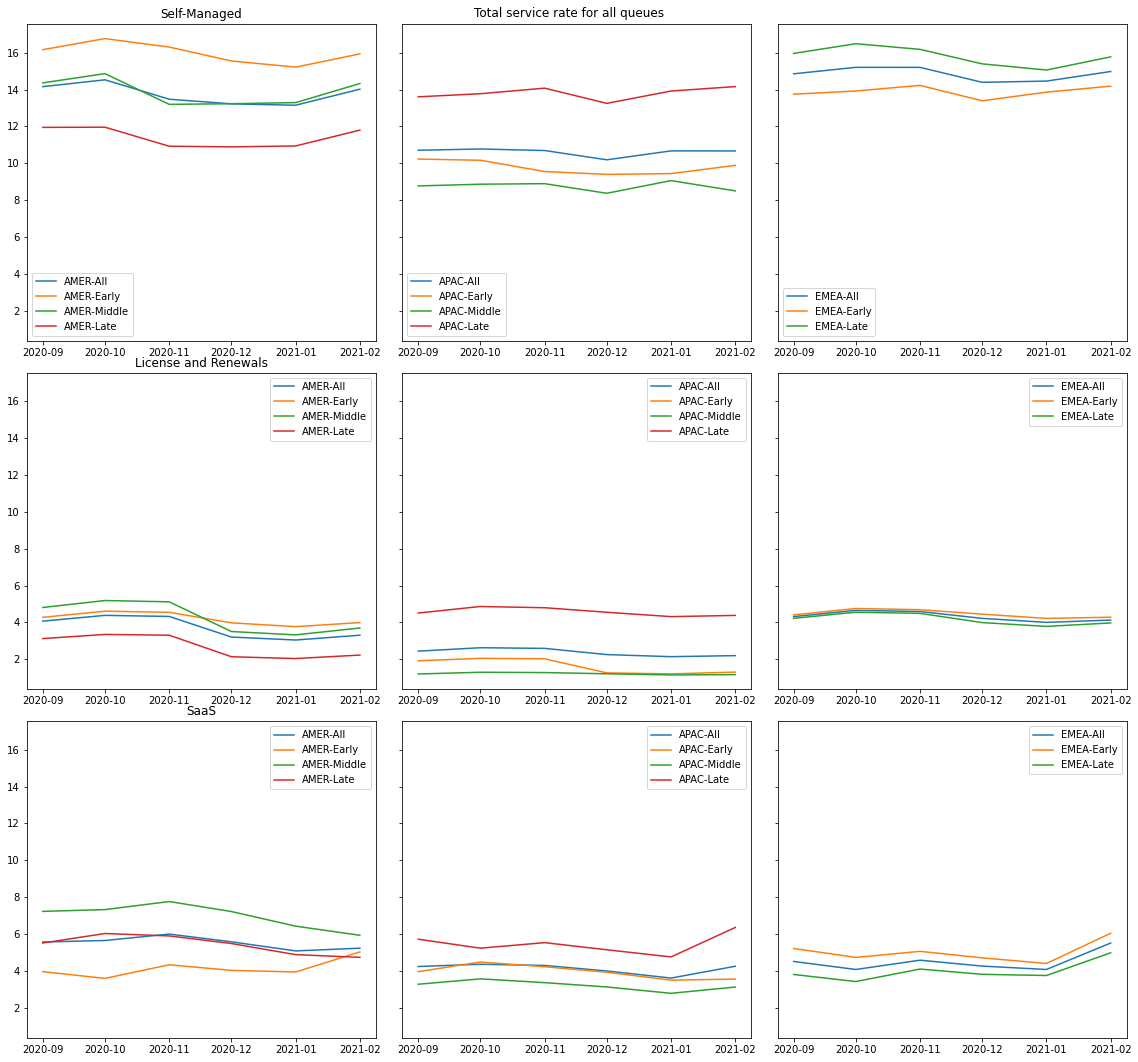

In [47]:
fig, ax = plt.subplots(3, 3, sharey=True, figsize=[16, 15])
fig.suptitle('Total service rate for all queues')
fig.tight_layout()

for i, focus in enumerate(['Self-Managed', 'License and Renewals', 'SaaS']):
    for region in ['AMER-All', 'AMER-Early', 'AMER-Middle', 'AMER-Late']:
        data = regional_avail_data[region]
        data = data[data['Focus'] == focus]
        ax[i, 0].plot(data['Month'], data['Total Service Rate'], label=region)
    ax[i, 0].set_title(focus)
    ax[i, 0].legend()

    for region in ['APAC-All', 'APAC-Early', 'APAC-Middle', 'APAC-Late']:
        data = regional_avail_data[region]
        data = data[data['Focus'] == focus]
        ax[i, 1].plot(data['Month'], data['Total Service Rate'], label=region)
    ax[i, 1].legend()

    for region in ['EMEA-All', 'EMEA-Early', 'EMEA-Late']:
        data = regional_avail_data[region]
        data = data[data['Focus'] == focus]
        ax[i, 2].plot(data['Month'], data['Total Service Rate'], label=region)
    ax[i, 2].legend()

plt.show()

In [52]:
arrivals_date_mask = arrival_rates_df['Month'] > '2020-08'
arrivals_form_mask = (arrival_rates_df['Form'] == 'Self-Managed') | (arrival_rates_df['Form'] == 'L&R')
filtered_arrival_rates_df = arrival_rates_df[arrivals_mask]
filtered_arrival_rates_df = filtered_arrival_rates_df[form_mask]

service_form_mask = (service_rates_df['Form'] == 'Self-Managed') | (service_rates_df['Form'] == 'L&R')
filtered_service_rates_df = service_rates_df[service_form_mask]

combined_df = pd.merge(filtered_arrival_rates_df, filtered_service_rates_df, on=['Form', 'Month', 'Region'])

print(combined_df.head())

     Region          Form      Month  Arrival Rate                 Focus  \
0  AMER-All           L&R 2020-09-01      2.409091  License and Renewals   
1  AMER-All  Self-Managed 2020-09-01      9.159091          Self-Managed   
2  AMER-All           L&R 2020-10-01      2.829545  License and Renewals   
3  AMER-All  Self-Managed 2020-10-01     10.268939          Self-Managed   
4  AMER-All           L&R 2020-11-01      2.595238  License and Renewals   

   Total Service Rate  75% Service Rate  
0            4.068516          3.051387  
1           14.159159         10.619369  
2            4.381684          3.286263  
3           14.530136         10.897602  
4            4.322860          3.242145  
<ipython-input-52-faa03f6b64c0>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  filtered_arrival_rates_df = filtered_arrival_rates_df[form_mask]


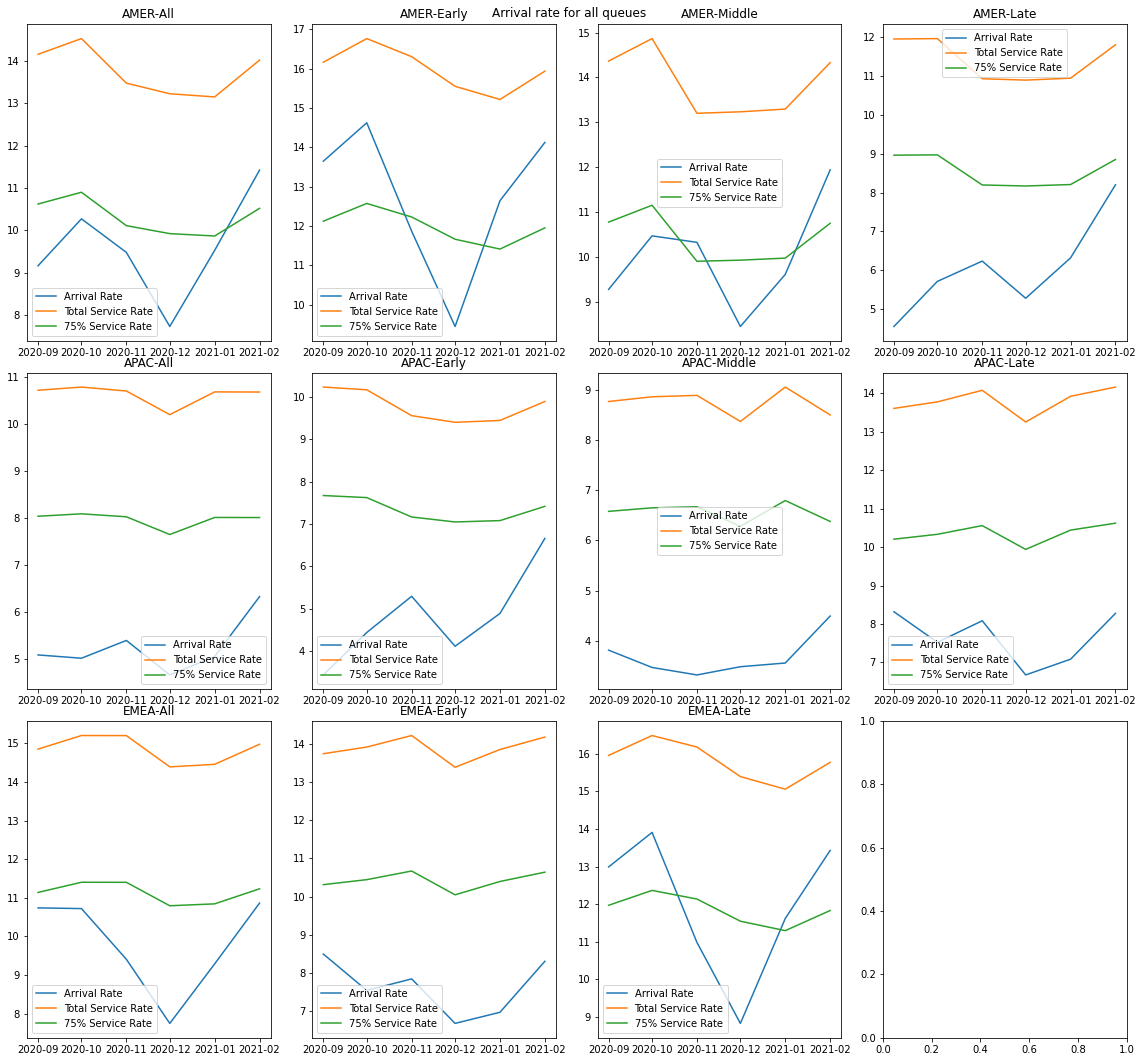

In [82]:
fig, ax = plt.subplots(3, 4, figsize=[16, 15])
fig.suptitle('Arrival rate for all queues')
fig.tight_layout()

form = 'Self-Managed'
for i, region in enumerate(['AMER-All', 'AMER-Early', 'AMER-Middle', 'AMER-Late']):
    mask = (combined_df['Region'] == region) & (combined_df['Form'] == form)
    data = combined_df[mask]
    ax[0, i].plot(data['Month'], data['Arrival Rate'], label='Arrival Rate')
    ax[0, i].plot(data['Month'], data['Total Service Rate'], label='Total Service Rate')
    ax[0, i].plot(data['Month'], data['75% Service Rate'], label='75% Service Rate')
    ax[0, i].set_title(region)
    ax[0, i].legend() 

for i, region in enumerate(['APAC-All', 'APAC-Early', 'APAC-Middle', 'APAC-Late']):
    mask = (combined_df['Region'] == region) & (combined_df['Form'] == form)
    data = combined_df[mask]
    ax[1, i].plot(data['Month'], data['Arrival Rate'], label='Arrival Rate')
    ax[1, i].plot(data['Month'], data['Total Service Rate'], label='Total Service Rate')
    ax[1, i].plot(data['Month'], data['75% Service Rate'], label='75% Service Rate')
    ax[1, i].set_title(region)
    ax[1, i].legend() 

for i, region in enumerate(['EMEA-All', 'EMEA-Early', 'EMEA-Late']):
    mask = (combined_df['Region'] == region) & (combined_df['Form'] == form)
    data = combined_df[mask]
    ax[2, i].plot(data['Month'], data['Arrival Rate'], label='Arrival Rate')
    ax[2, i].plot(data['Month'], data['Total Service Rate'], label='Total Service Rate')
    ax[2, i].plot(data['Month'], data['75% Service Rate'], label='75% Service Rate')
    ax[2, i].set_title(region)
    ax[2, i].legend() 

plt.show()

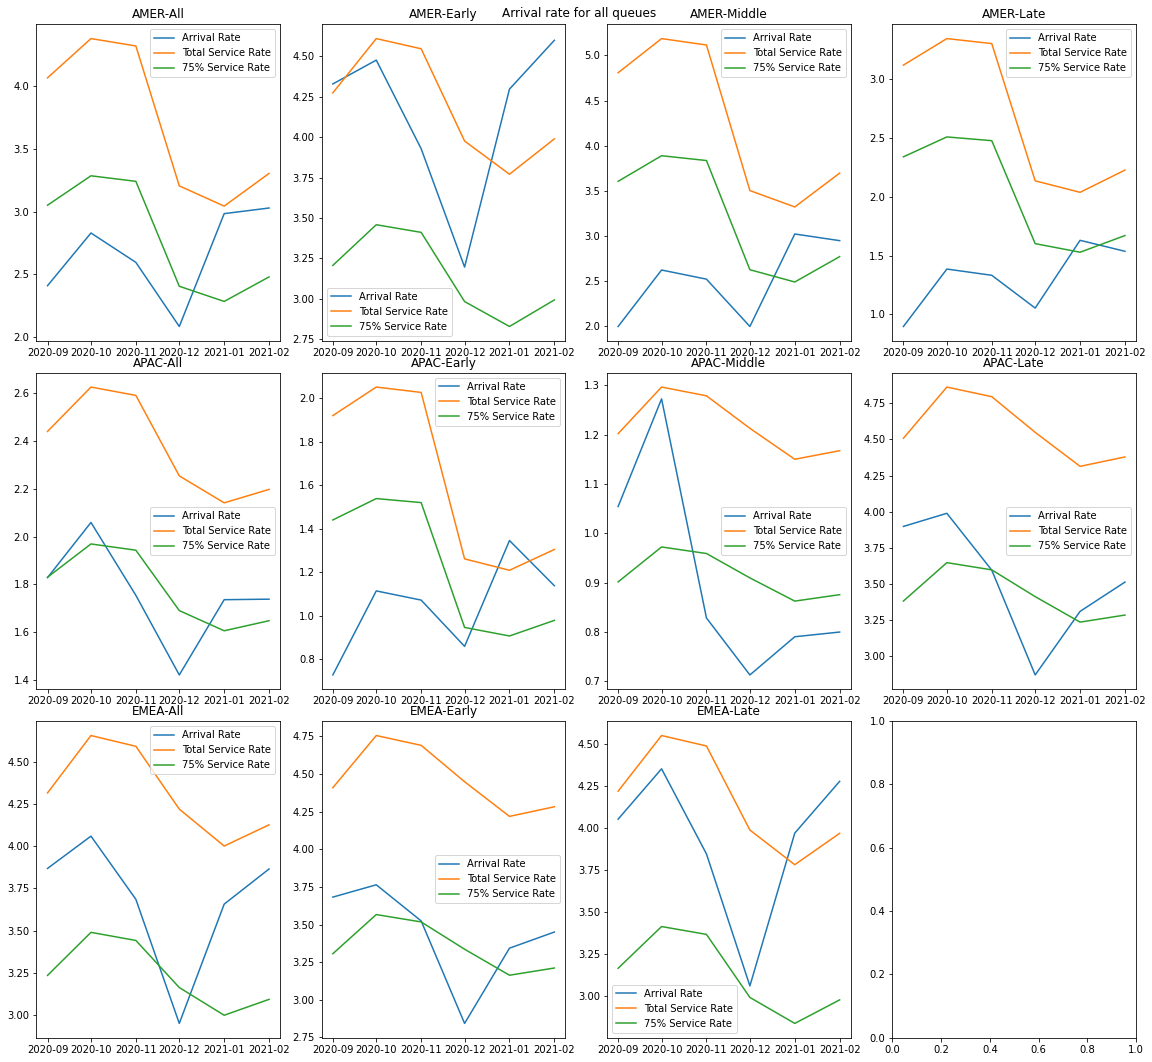

In [83]:
fig, ax = plt.subplots(3, 4, figsize=[16, 15])
fig.suptitle('Arrival rate for all queues')
fig.tight_layout()

form = 'L&R'
for i, region in enumerate(['AMER-All', 'AMER-Early', 'AMER-Middle', 'AMER-Late']):
    mask = (combined_df['Region'] == region) & (combined_df['Form'] == form)
    data = combined_df[mask]
    ax[0, i].plot(data['Month'], data['Arrival Rate'], label='Arrival Rate')
    ax[0, i].plot(data['Month'], data['Total Service Rate'], label='Total Service Rate')
    ax[0, i].plot(data['Month'], data['75% Service Rate'], label='75% Service Rate')
    ax[0, i].set_title(region)
    ax[0, i].legend() 

for i, region in enumerate(['APAC-All', 'APAC-Early', 'APAC-Middle', 'APAC-Late']):
    mask = (combined_df['Region'] == region) & (combined_df['Form'] == form)
    data = combined_df[mask]
    ax[1, i].plot(data['Month'], data['Arrival Rate'], label='Arrival Rate')
    ax[1, i].plot(data['Month'], data['Total Service Rate'], label='Total Service Rate')
    ax[1, i].plot(data['Month'], data['75% Service Rate'], label='75% Service Rate')
    ax[1, i].set_title(region)
    ax[1, i].legend() 

for i, region in enumerate(['EMEA-All', 'EMEA-Early', 'EMEA-Late']):
    mask = (combined_df['Region'] == region) & (combined_df['Form'] == form)
    data = combined_df[mask]
    ax[2, i].plot(data['Month'], data['Arrival Rate'], label='Arrival Rate')
    ax[2, i].plot(data['Month'], data['Total Service Rate'], label='Total Service Rate')
    ax[2, i].plot(data['Month'], data['75% Service Rate'], label='75% Service Rate')
    ax[2, i].set_title(region)
    ax[2, i].legend() 

plt.show()